In [1]:
import os

NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
from yellowbrick.cluster import KElbowVisualizer
scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

In [2]:
def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) 
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [3]:
def find_optimal_number_of_cluster(group, k_max):
    if type(group) == pd.core.frame.DataFrame:
        group = np.array(group.values.tolist())
    if type(group) == []:
         group = np.array(group)
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    sse = []
    for k in range(1,k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [4]:
def clustering(df, df_result, x, y):
    df_result = pd.DataFrame()
    df_normalized = normalize(df)
    if x != y and df[y].dtypes != object:
        group = df_normalized[[x, y]]
        X = np.array(group.values.tolist())
        NUM_CLUSTER, sse = find_optimal_number_of_cluster(X, 11)

        centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
        key = x + "_" + y
        df_result[key] = labels
        df[key] = labels
        sns.scatterplot(data=df, x=x, y=y, alpha=0.8, c=labels, s=50, hue=labels)
        sns.scatterplot(x=centers[:, 0], y=centers[:, 1],  s=250, zorder=2, marker="x", legend=None);
    return df_result

In [5]:
def normalize(df):
    normalize = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(normalize, columns=df.columns)
    return df_normalized

### Correlation

([<matplotlib.axis.YTick at 0x150d8769af0>,
 [Text(0, 0.5, 'exports'),
  Text(0, 1.5, 'health'),
  Text(0, 2.5, 'imports'),
  Text(0, 3.5, 'income'),
  Text(0, 4.5, 'inflation'),
  Text(0, 5.5, 'life_expec'),
  Text(0, 6.5, 'total_fer'),
  Text(0, 7.5, 'gdpp')])

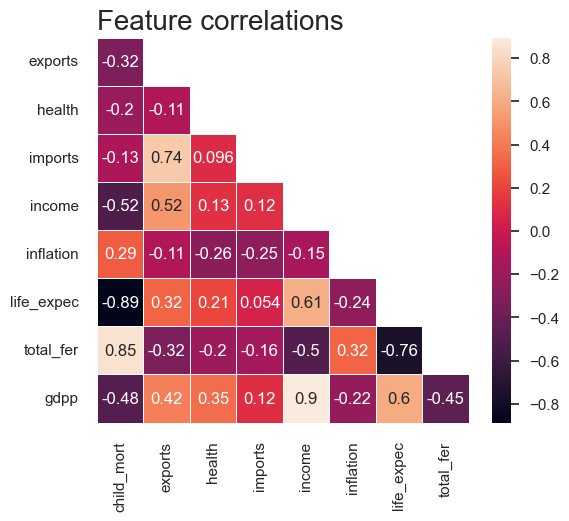

In [6]:
raw_data = pd.read_csv('dataset/Country-data.csv')
df = raw_data.copy()

cors = np.ones_like(df.corr(), dtype=bool)
mask = np.triu(cors)
mask = mask[1:, :-1]

plt.figure(figsize=(6,5))
plt.rcParams["figure.autolayout"] = True

df_corr = df.corr().iloc[1:,:-1]
sns.heatmap(df_corr, annot=True, linewidth=0.4, mask=mask)
plt.title("Feature correlations", loc="left", fontsize = 20)

plt.yticks(plt.yticks()[0], labels=df_corr.index,rotation=0)

We can see the following from the correlation heatmap:

* As expected GDPP and income are highly correlated.
* Number of children born per woman is highly correlated with child mortality, which makes sense.
* Imports and exports are highly correlated as expected.
* Life expectancy is highly negatively correlated with child mortality.
* Life expectancy is correlated with income
* Life expectancy is correlated with GDPP

We can safely drop life expectancy, total fertility and income as they are all very highly correlated to other features

In [7]:
df_clear = df.drop(columns = ['income','country', 'life_expec', 'total_fer']).copy()

### Data Analysis

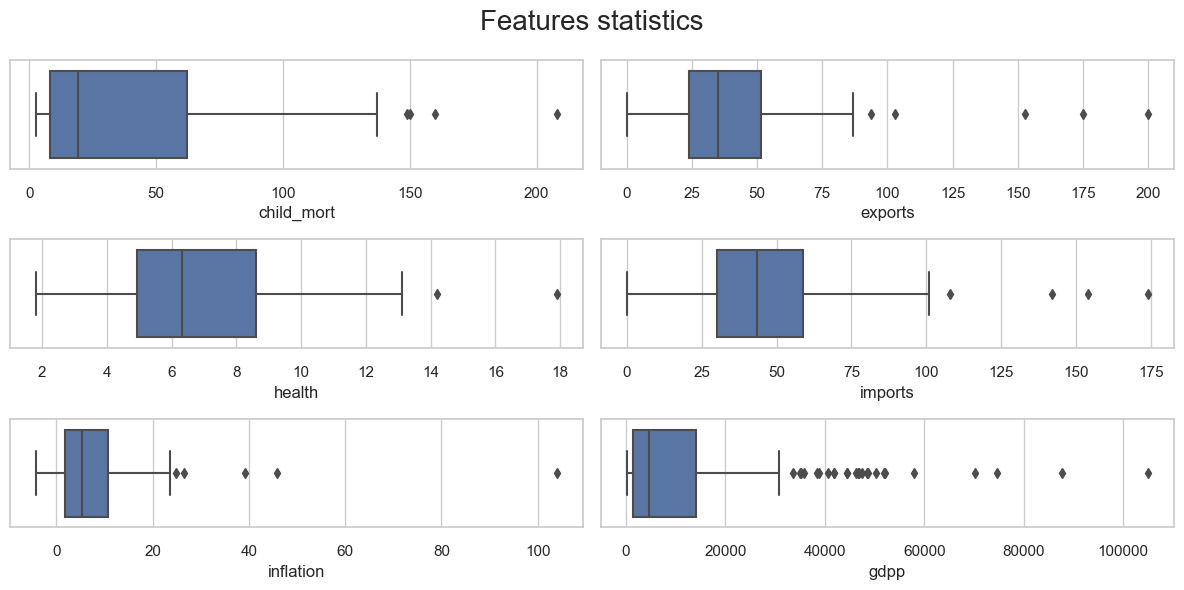

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
plt.suptitle("Features statistics", fontsize=20)
ax = ax.flatten()
for index, column in enumerate(df_clear.columns):
    sns.boxplot(x=df_clear[column], ax=ax[index])

GDPP, inflation, income, imports and exports have many outliers. We cannot change these as these are actually values for the country and dropping them or changing them would change the message from the data.

### Normilaze

In [9]:
df_normalized = normalize(df_clear)

### K-mean Find count clusters

In [10]:
Y_label = "child_mort"
X_label = "health"
k_max = 11
group = df_normalized[[X_label,Y_label]]
X = np.array(group.values.tolist())
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, k_max)

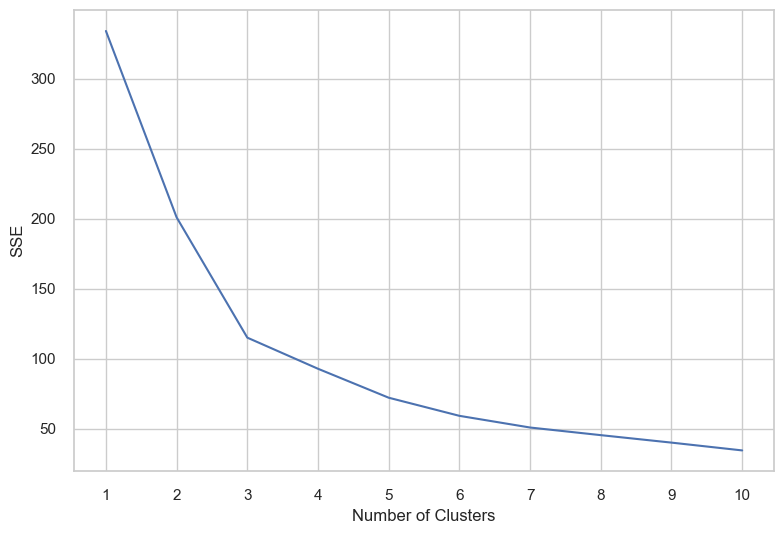

In [11]:
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

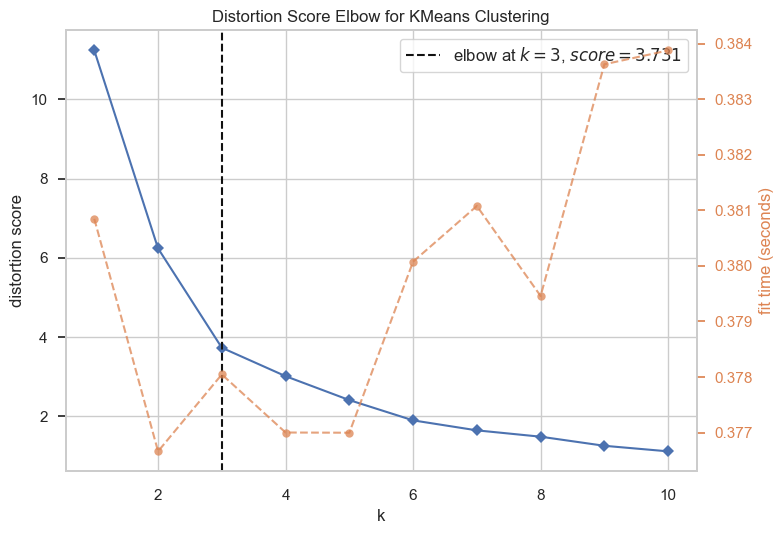

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,k_max))
visualize.fit(group)
visualize.poof()

### Visual

1    103
0     34
2     30
Name: gdpp_child_mort, dtype: int64

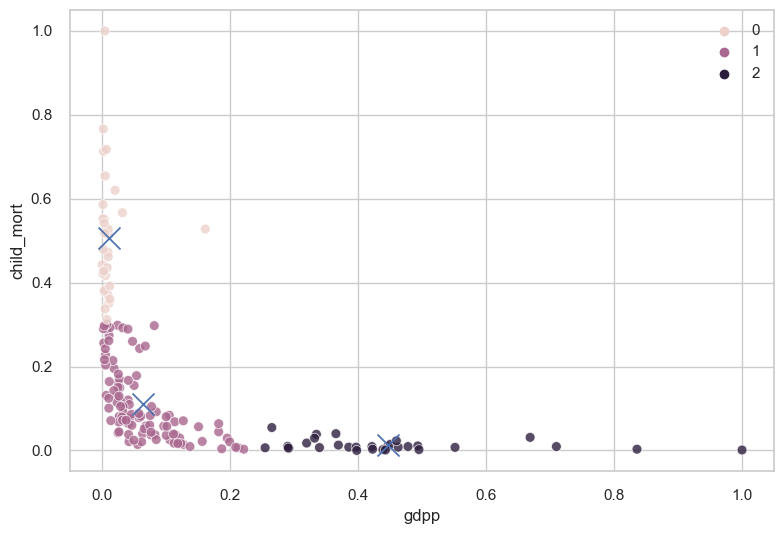

In [13]:
results = pd.DataFrame()
results = clustering(df_normalized, results, 'gdpp', 'child_mort')
results.gdpp_child_mort.value_counts()

1    86
0    51
3    25
2     5
Name: gdpp_imports, dtype: int64

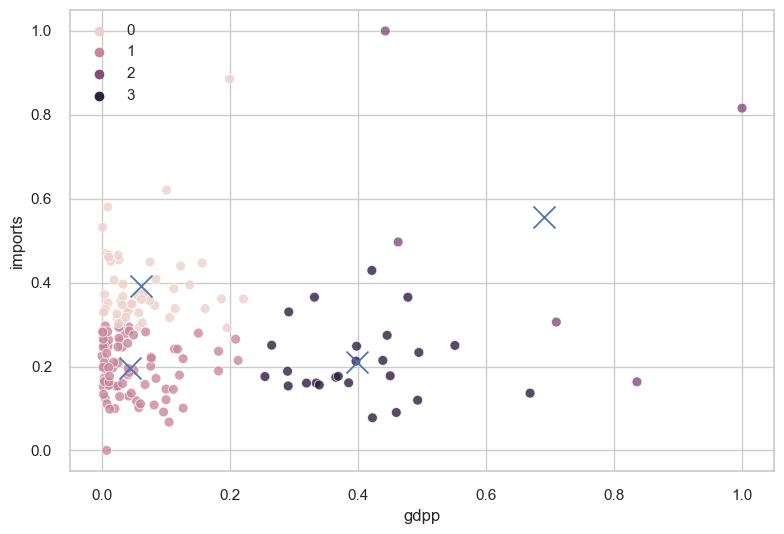

In [14]:
results = clustering(df_normalized, results, 'gdpp', 'imports')
results.gdpp_imports.value_counts()

1    98
0    47
2    22
Name: gdpp_health, dtype: int64

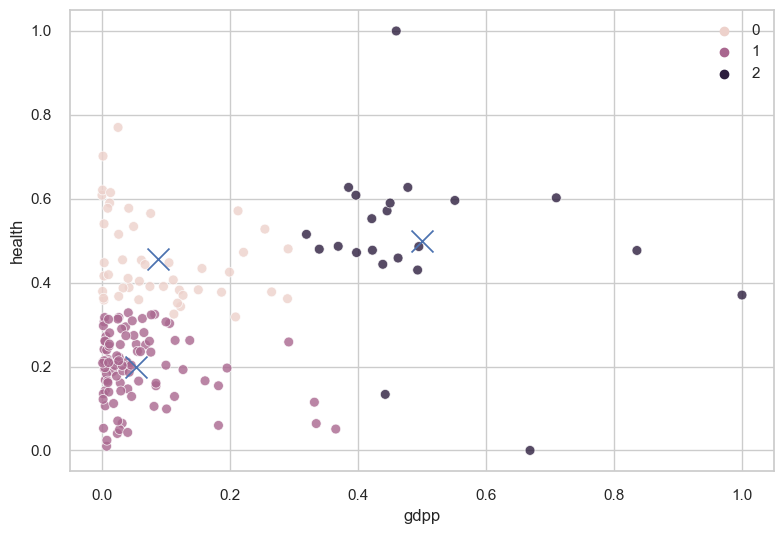

In [15]:
results = clustering(df_normalized, results, 'gdpp', 'health')
results.gdpp_health.value_counts()

In [29]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(df_normalized)

df['cluster'] = model.labels_
df.cluster.value_counts()

0    72
2    34
1    32
3    29
Name: cluster, dtype: int64

In [31]:
clusters = df.groupby(['cluster']).mean()
clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,27.059722,43.803875,5.117222,47.985638,12859.305556,8.424875,71.552778,2.549861,6462.972222
1,20.971875,40.943750,9.119063,52.321875,13998.437500,6.087906,72.871875,2.364688,8998.843750
2,106.402941,28.232941,6.311471,43.238235,3045.382353,12.220147,58.002941,5.290882,1374.029412
3,5.310345,49.696552,9.082069,42.458621,47786.206897,2.850931,80.241379,1.833103,47068.965517


In [32]:
df[df.cluster==2].head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,2
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,2
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,2
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,2
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,2
28,Cameroon,108.0,22.20,5.13,27.0,2660,1.910,57.3,5.11,1310,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,2
32,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897,2
36,Comoros,88.2,16.50,4.51,51.7,1410,3.870,65.9,4.75,769,2
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334,2


In [18]:
KMeans_method=cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300)
SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans')
dbscan = cluster.DBSCAN(eps=0.25)

centers, labels = find_clusters(X, NUMBER_CLUSTER, rseed=0)

labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_

labels_spectral = SpectralClustering_method.fit_predict(X)

scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)

labels_dbscan = dbscan.labels_

df_normalized['find'] = labels
df_normalized['k-mean'] = labels_k_mean
df_normalized['spectral'] = labels_spectral
df_normalized['dbscan'] = labels_dbscan

In [19]:
labels_K_Mean = np.insert(np.array(df_normalized.loc[:,["k-mean","country"]].groupby("k-mean").count().values.tolist()).reshape(-1).astype(str), 0, "K-Mean")
labels_AlgoExp_Max = np.insert(np.array(df_normalized.loc[:,["find","country"]].groupby("find").count().values.tolist()).reshape(-1).astype(str), 0, "AlgoExp_Max")
labels_Spectral = np.insert(np.array(df_normalized.loc[:,["spectral","country"]].groupby("spectral").count().values.tolist()).reshape(-1).astype(str), 0, "Spectral")
labels_Dbscan = np.insert(np.array(df_normalized.loc[:,["dbscan","country"]].groupby("dbscan").count().values.tolist()).reshape(-1).astype(str), 0, "Dbscan")
print(labels_K_Mean, labels_AlgoExp_Max, labels_Spectral, labels_Dbscan, sep="\n")

KeyError: "['country'] not in index"

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), sharex=True, sharey=True)


sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=ax1)
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=ax1, legend=None)
ax1.legend(labels=labels_K_Mean)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="find", s=50,alpha=1, palette="flare", ax=ax2)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=ax2, legend=None)
ax2.legend(labels=labels_AlgoExp_Max)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=ax3)
ax3.legend(labels=labels_Spectral)

sns.scatterplot(data=df_normalized, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=ax4)
ax4.legend(labels=labels_Dbscan)

fig.suptitle("Сomparison of different clasification methods X: {} Y: {}".format(X_label, Y_label))
plt.savefig('img/{} clasification methods.jpg'.format(Y_label))

In [ ]:
def result_def(df, target, limit=0):
    df = normalize(df)
    if limit==0: limit=len(df.columns)-2
    df_result = pd.DataFrame(df.country, columns=["country"])
    df_result[target]=df[target]
    
    fig, axes = plt.subplots(1, limit, figsize=(3*limit, 6))
    for index, y_label in enumerate(df.columns[1:limit+1]):
        print("iteration: {} x: {} target: {}".format(index+1, y_label, target))
        if target != y_label and df[y_label].dtypes != object:
            group = df[[y_label,target]]
            X = np.array(group.values.tolist())
            
            NUM_CLUSTER, see = find_optimal_number_of_cluster(X, 11)
            print("Count clusters: {}".format(NUM_CLUSTER))
            
            centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
            key='cluster_'+y_label
            df_result[key] = labels
            df[key] = labels
            
            axes[index].get_xaxis().set_visible(False)
            sns.scatterplot(data=df, x=target, y=y_label, hue=key, s=50,alpha=0.45, palette="flare", ax=axes[index])
            sns.scatterplot(x=centers[:, 1], y=centers[:, 0], s=250, zorder=2, marker="x", ax=axes[index], palette=["black"]);
            sns.move_legend(axes[index], "upper center", ncol=2, frameon=False, bbox_to_anchor=(.5, 0), title=y_label)
            axes[index].set(ylabel=None)
            axes[index].label_outer()
    fig.suptitle("Сomparison of different features using Exp max method with X label: {}".format(target))
    plt.savefig('img/{} clasification features.jpg'.format(target))
    df_result.to_csv('result_cluster.csv', encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('dataset/Country-data.csv')
result_def(df.copy(), "gdpp")

In [ ]:
df = pd.read_csv('result_cluster.csv')

In [ ]:
df.head()

In [ ]:
df_result = df[(df.cluster_child_mort == 0)
               &(df.cluster_income==0)
               &(df.cluster_inflation==1)].sort_values("gdpp").reset_index(drop=True)

In [ ]:
df_result